In [ ]:
! pip install scikit-multiflow river==0.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.6/450.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for river: filename=river-0.7.0-cp310-cp310-linux_x86_64.whl size=2361574 sha256=d582e631998c91622651dbb55ef5cfe9fd71cd13abdc76cad603cf00f9452211
  Stored in directory: /root/.cache/pip/wheels/71/e9/7e/105173d51ebb5262f6f2dc4f6a5003ec86365255e8fd989733
  Created wheel for scikit-multiflow: filename=scikit_multiflow-0.5.3-cp310-cp310-linux_x86_64.whl size=1254821 sha256=6a9859ddb3eae2cf2f7444aca51bcc274ff41cae8cf06dec153ce5291d621390
  Stored in directory: /root/.cache/pip/wheels/6e/1b/56/45b17a6cf203d98000a45976cb0dd0c4c3f11960e6a505f231
Successfully built river scikit-multiflow


In [ ]:
!pip install optunity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for optunity: filename=Optunity-1.1.1-py3-none-any.whl size=72027 sha256=56c346f4f419e7aff648123cc98946847069fb2e7d186924d8a49692d83c07ca
  Stored in directory: /root/.cache/pip/wheels/83/98/40/b9956c3386a045f035f9edbf894edd04713db92f29fb58a225
Successfully built optunity


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from random import randint
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

from river import metrics
from river.drift import DDM, ADWIN
from river import stream, tree, ensemble
from river import tree,neighbors,naive_bayes,ensemble,linear_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## FumeHood

In [ ]:
fumeHood_Data = pd.read_csv('/content/drive/MyDrive/DigitalTwin/FumeHood.csv')

In [ ]:
def remove_null_values(df):
    # Count the number of null values in the DataFrame
    num_null_values = df.isnull().sum().sum()

    # Remove rows with null values
    cleaned_df = df.dropna()

    # Output the number of null values removed
    print("Number of null values removed:", num_null_values)

    return cleaned_df

# Remove all the null value records from the dataset
fumeHood_Data = remove_null_values(fumeHood_Data)

Number of null values removed: 51


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def inject_noise(data, noise_ratio, noise_level, noise_distribution='normal'):
    # Create a copy of the original data
    noisy_data = data.copy()

    # Calculate the number of rows to inject noise
    num_noise_rows = int(len(data) * noise_ratio)

    # Select random rows to inject noise
    noise_indices = np.random.choice(data.index, num_noise_rows, replace=False)
        # Add noise to selected rows for temperature, humidity, and airflow columns
    for idx in noise_indices:
      if noise_distribution == 'normal':
        noisy_data.loc[idx, 'temperature'] += np.random.normal(0, noise_level)
        noisy_data.loc[idx, 'humidity'] += np.random.normal(0, noise_level)
        noisy_data.loc[idx, 'airflow'] += np.random.normal(0, noise_level)

      elif noise_distribution == 'exponential':
        anomaly_type = np.random.choice(['Positive Shift', 'Negative Shift'])
        if anomaly_type == 'Positive Shift':
          noisy_data.loc[idx, 'temperature'] += np.random.normal(0, noise_level)
          noisy_data.loc[idx, 'humidity'] += np.random.normal(0, noise_level)
          noisy_data.loc[idx, 'airflow'] += np.random.normal(0, noise_level)
        else:

        # noisy_data.loc[idx, 'temperature'] += np.random.poisson(noise_level)
        # noisy_data.loc[idx, 'humidity'] += np.random.poisson(noise_level)
        # noisy_data.loc[idx, 'airflow'] += np.random.poisson(noise_level)
          noisy_data.loc[idx, 'temperature'] += np.random.uniform(-noise_level, noise_level)
          noisy_data.loc[idx, 'humidity'] += np.random.uniform(-noise_level, noise_level)
          noisy_data.loc[idx, 'airflow'] += np.random.uniform(-noise_level, noise_level)
    # Create a new column 'label' to indicate anomalies
    noisy_data['label'] = 'no_anomaly'  # Initialize all labels as 'no_anomaly'
    noisy_data.loc[noise_indices, 'label'] = 'anomaly'  # Update label for noisy rows

    return noisy_data

def split_train_test_with_anomalies(data, anomaly_column, train_noise_ratio, test_anomaly_ratio, train_noise_level, test_noise_level):
    # Split data into train and test
    train_data, test_data = train_test_split(data, test_size=0.4, random_state=42)

    # Inject noise into the training set
    train_data = inject_noise(train_data, noise_ratio=train_noise_ratio, noise_level=train_noise_level, noise_distribution='normal')

    # Inject noise into the test set
    test_data = inject_noise(test_data, noise_ratio=test_anomaly_ratio, noise_level=test_noise_level,noise_distribution='exponential')

    return train_data, test_data

# Example usage
train_data_fumehood, test_data_fumehood = split_train_test_with_anomalies(fumeHood_Data, 'label', 0.01, 0.85, 0.1, 0.4) ## 0.01 is the percentage of the anomalies in the training set, 0.85 is the percentage of anomalies in testing set, 0.1 is



# def plot_combined_data(train_data, test_data, features):
#     num_features = len(features)
#     fig, axs = plt.subplots(1, num_features, figsize=(6*num_features, 6))

#     for i, feature in enumerate(features):
#         # Combine anomalies from both train and test data
#         anomalies_train = train_data[train_data['label'] == 'anomaly'][feature]
#         anomalies_test = test_data[test_data['label'] == 'anomaly'][feature]
#         anomalies_combined = pd.concat([anomalies_train, anomalies_test])

#         # Combine non-anomalies from both train and test data
#         non_anomalies_train = train_data[train_data['label'] == 'no_anomaly'][feature]
#         non_anomalies_test = test_data[test_data['label'] == 'no_anomaly'][feature]
#         non_anomalies_combined = pd.concat([non_anomalies_train, non_anomalies_test])

#         # Plot anomalies
#         axs[i].plot(anomalies_combined.index, anomalies_combined, 'ro', label='Anomalies')

#         # Plot non-anomalies
#         axs[i].plot(non_anomalies_combined.index, non_anomalies_combined, 'bo', label='Normal')

#         axs[i].set_ylabel(feature,fontsize=20)
#         # axs[i].set_title(f'{feature} - Data')
#         axs[i].legend()

#     plt.xlabel('Number of samples', fontsize=20)


#     # Adjust font sizes for readability
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)
#     plt.legend(loc='upper right', fontsize=16)
#     plt.tight_layout()
#     plt.show()




#     plt.show()
# # Example usage with all features
# features = ['temperature', 'humidity', 'airflow']
# plot_combined_data(train_data_fumehood, test_data_fumehood, features)


# # Example usage with all features
# features = ['temperature', 'humidity', 'airflow']
# plot_combined_data(train_data_fumehood, test_data_fumehood, features)



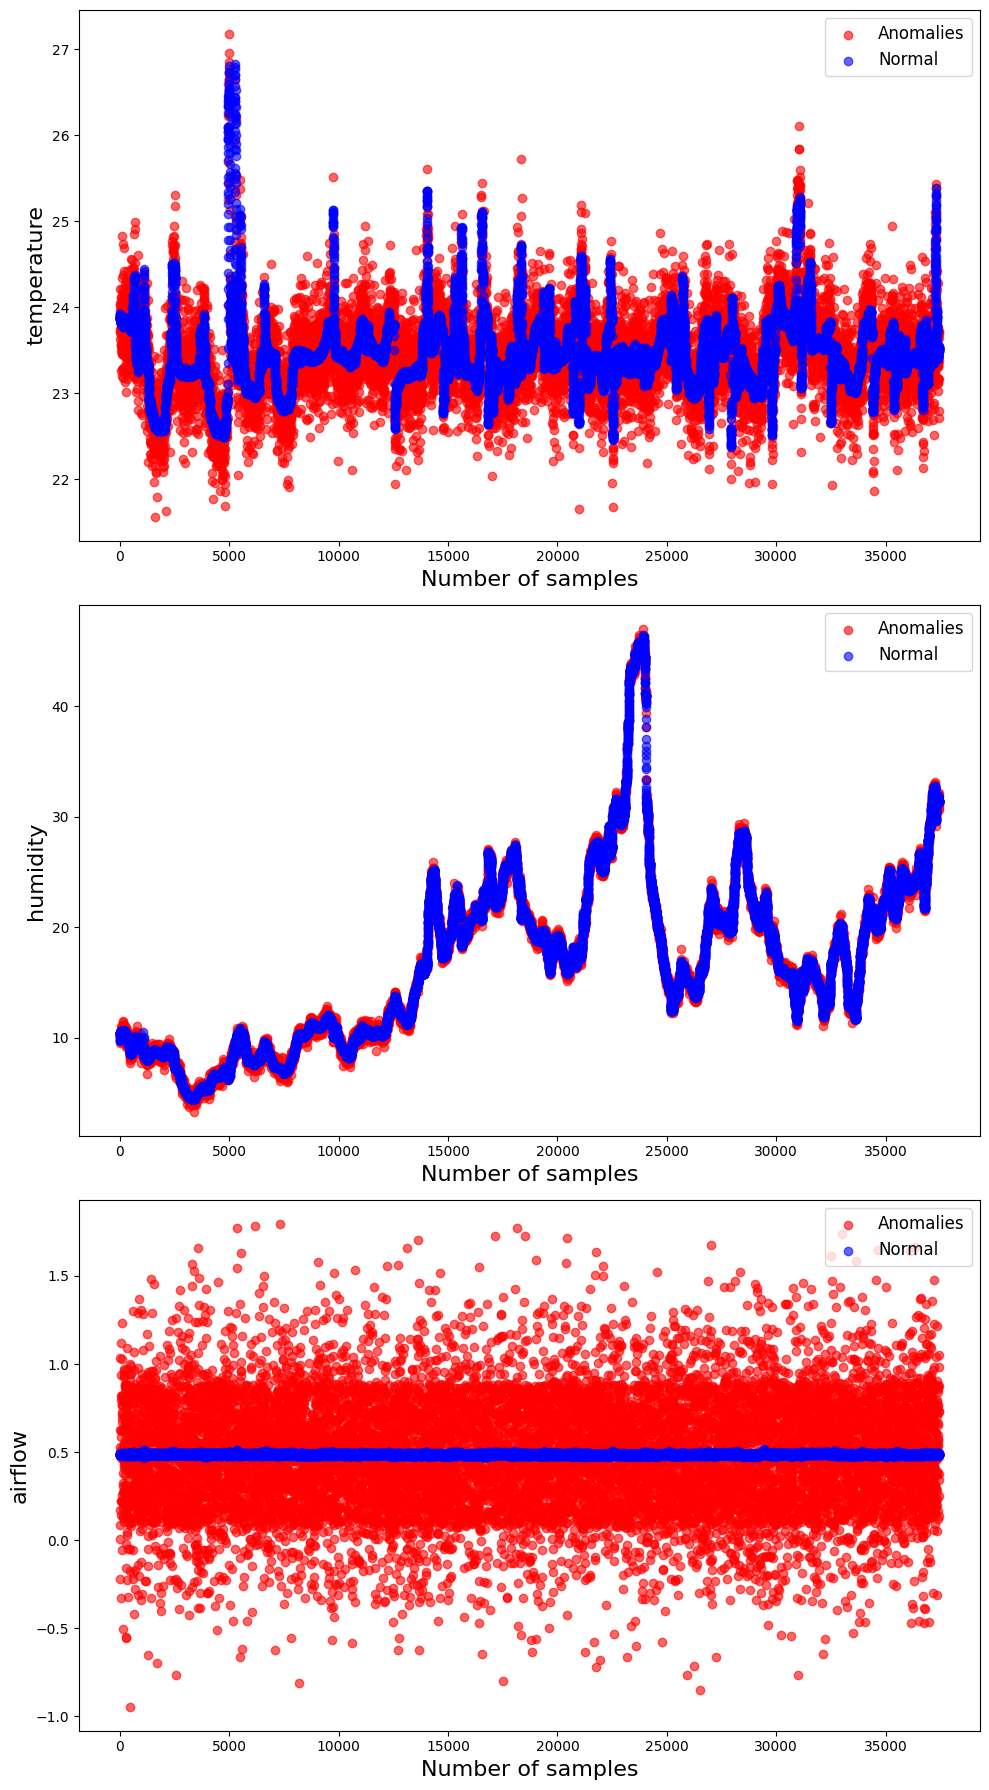

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_separate_features(train_data, test_data, features):
    num_features = len(features)
    fig, axs = plt.subplots(num_features, 1, figsize=(10, 6 * num_features))  # Adjust the figure size

    if num_features == 1:
        axs = [axs]  # Make sure axs is iterable if there's only one plot

    for i, feature in enumerate(features):
        # Combine anomalies from both train and test data
        anomalies_train = train_data[train_data['label'] == 'anomaly'][feature]
        anomalies_test = test_data[test_data['label'] == 'anomaly'][feature]
        anomalies_combined = pd.concat([anomalies_train, anomalies_test])

        # Combine non-anomalies from both train and test data
        non_anomalies_train = train_data[train_data['label'] == 'no_anomaly'][feature]
        non_anomalies_test = test_data[test_data['label'] == 'no_anomaly'][feature]
        non_anomalies_combined = pd.concat([non_anomalies_train, non_anomalies_test])

        # Plot anomalies
        axs[i].scatter(anomalies_combined.index, anomalies_combined, c='red', label='Anomalies', alpha=0.6)

        # Plot non-anomalies
        axs[i].scatter(non_anomalies_combined.index, non_anomalies_combined, c='blue', label='Normal', alpha=0.6)

        axs[i].set_ylabel(feature, fontsize=16)
        axs[i].set_xlabel('Number of samples', fontsize=16)
        axs[i].legend(loc='upper right', fontsize=12)

        # Adjust x-axis ticks to prevent overlapping
        axs[i].xaxis.set_major_locator(plt.MaxNLocator(10))

    plt.tight_layout()
    plt.show()

# Example usage
features = ['temperature', 'humidity', 'airflow']
plot_separate_features(train_data_fumehood, test_data_fumehood, features)


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Sample function to split anomalies/non-anomalies
def split_anomalies(data):
    anomalies = data[data['label'] == 'anomaly']
    non_anomalies = data[data['label'] == 'no_anomaly']
    return anomalies, non_anomalies

# Sample function to calculate summary statistics
def calculate_summary_statistics(data):
    summary_stats = {
        'Mean': data.mean(),
        'Std': data.std()
    }
    return summary_stats

# Sample function to perform hypothesis test (Kolmogorov-Smirnov test)
def perform_hypothesis_test(train_data, test_data):
    ks_statistics = {}
    for feature in ['temperature', 'humidity', 'airflow']:
        train_anomalies = train_data[train_data['label'] == 'anomaly'][feature]
        test_anomalies = test_data[test_data['label'] == 'anomaly'][feature]
        statistic, p_value = ks_2samp(train_anomalies, test_anomalies)
        ks_statistics[feature] = {'Statistic': statistic, 'p-value': p_value}
    return ks_statistics

# Example usage
# Assuming train_data and test_data are your training and test datasets with anomaly labels
train_anomalies, train_non_anomalies = split_anomalies(train_data_fumehood)
test_anomalies, test_non_anomalies = split_anomalies(test_data_fumehood)

# Calculate summary statistics for anomalies in train and test datasets
train_summary_stats = calculate_summary_statistics(train_anomalies[['temperature', 'humidity', 'airflow']])
test_summary_stats = calculate_summary_statistics(test_anomalies[['temperature', 'humidity', 'airflow']])

# Perform hypothesis test
ks_statistics = perform_hypothesis_test(train_anomalies, test_anomalies)

# Print summary statistics and hypothesis test results
print("Summary Statistics for Anomalies:")
print("Train Data:")
print(train_summary_stats)
print("\nTest Data:")
print(test_summary_stats)

print("\nKolmogorov-Smirnov Test Results for Anomalies:")
print(ks_statistics)


Summary Statistics for Anomalies:
Train Data:
{'Mean': temperature    23.442066
humidity       17.155910
airflow         0.480355
dtype: float64, 'Std': temperature    0.356186
humidity       8.831765
airflow        0.095287
dtype: float64}

Test Data:
{'Mean': temperature    23.450901
humidity       16.795429
airflow         0.484338
dtype: float64, 'Std': temperature    0.515754
humidity       7.839246
airflow        0.325518
dtype: float64}

Kolmogorov-Smirnov Test Results for Anomalies:
{'temperature': {'Statistic': 0.10084289531593837, 'p-value': 0.021186939117348032}, 'humidity': {'Statistic': 0.04416569362734091, 'p-value': 0.7669703153039429}, 'airflow': {'Statistic': 0.2958175214442898, 'p-value': 1.471053164123114e-17}}


In [ ]:
import lightgbm as lgb
classifier = lgb.LGBMClassifier()

[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training from score 4.597507


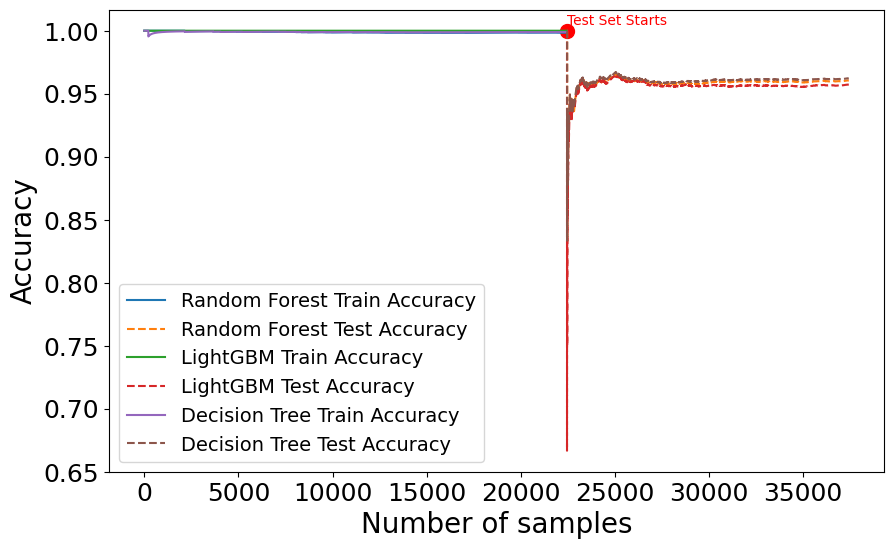

In [ ]:
train_and_plot_anomaly_detection_models(train_data_fumehood, test_data_fumehood, "FumeHood")

In [ ]:
import lightgbm as lgb
classifier = lgb.LGBMClassifier()

[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training from score 4.597507


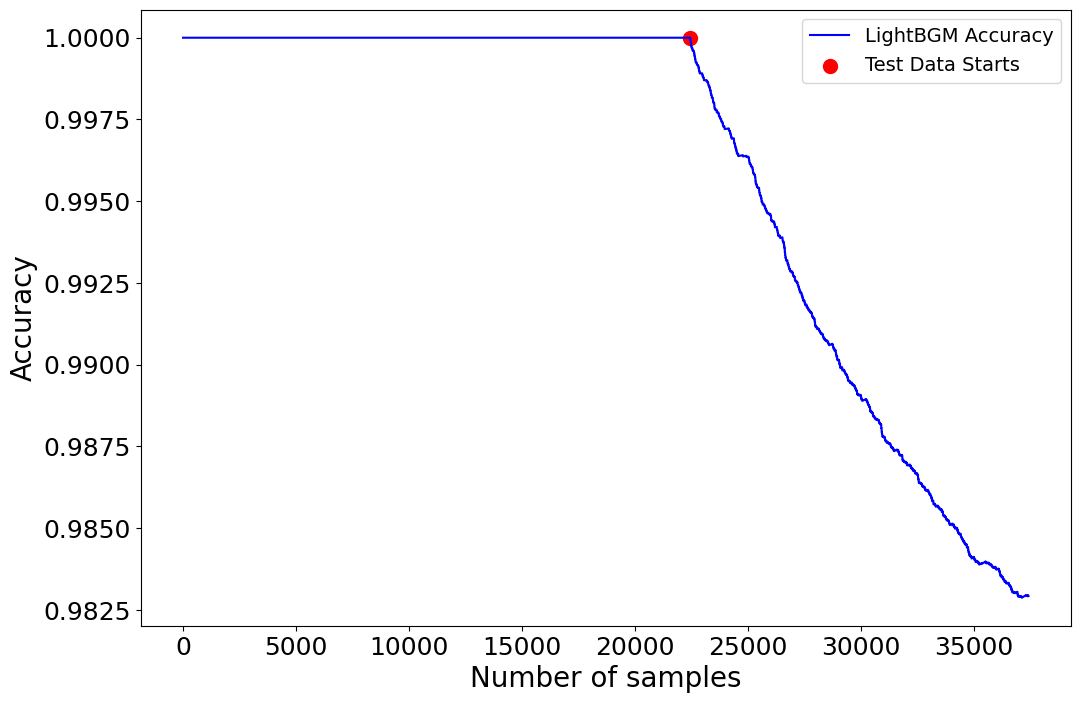

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assuming you have already split your data into train and test sets
# train_data_fumehood, test_data_fumehood

# Extract features and labels
X_train = train_data_fumehood.drop(columns=['label']).values
y_train = train_data_fumehood['label'].values
X_test = test_data_fumehood.drop(columns=['label']).values
y_test = test_data_fumehood['label'].values

# Train the LightGBM model
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

# Predict on the combined train and test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Combine train and test labels for calculation of accuracy over time
y_combined = np.concatenate((y_train, y_test))
y_pred_combined = np.concatenate((y_pred_train, y_pred_test))

# Calculate accuracy over time for combined data
acc_combined = []
acc_sum_combined = 0
test_start_idx = len(y_train)  # Index where test data starts
for i in range(len(y_combined)):
    if y_combined[i] == y_pred_combined[i]:
        acc_sum_combined += 1
    accuracy_combined = acc_sum_combined / (i + 1)
    acc_combined.append(accuracy_combined)

# Plot the accuracy changes over time for combined data
plt.figure(figsize=(12, 8))
plt.plot(acc_combined, label='LightBGM Accuracy', color='blue')

# Mark the point where test data starts
plt.scatter(test_start_idx, acc_combined[test_start_idx], s=100, c='r', marker='o', label='Test Data Starts')
# plt.text(test_start_idx, acc_combined[test_start_idx] + 0.01, 'Test Data Start', c='r')

plt.xlabel('Number of samples', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14)

# plt.legend()
plt.show()
#

In [ ]:

## converting it to dataframe
X_train = pd.DataFrame(train_data_fumehood.drop(columns=['label']).values)
y_train = pd.DataFrame(train_data_fumehood['label'].values)
X_test= pd.DataFrame(test_data_fumehood.drop(columns=['label']).values)
y_test= pd.DataFrame(test_data_fumehood['label'].values)

In [ ]:
def oasw(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    i=0
    yt = []
    yp = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    metric = metrics.Accuracy()

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        yi=next(iter(yi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))[0]      # make a prediction
        metric = metric.update(yi, y_pred)  # update the metric

        # Store the y_test, y_pred, and x_test
        yt.append(yi)
        yp.append(y_pred)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)
            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1
    score=metric.get()
    print(str(a)+" "+str(b)+" "+str(win1)+" "+str(win2)+" "+str(score)) # Output the hyperparameter values and corresponding accuracy
    return score

In [ ]:
import optunity
import optunity.metrics

search = {
    'a': [0.95,0.99],
    'b': [0.90,0.98],
    'win1': [200,1000],
    'win2': [1000,5000],
         }

optimal_configuration, info, _ = optunity.maximize(oasw,
                                                  solver_name='particle swarm',
                                                  num_evals=10,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training from score 4.597507
0.987 0.921 320 1523 0.9573146292585171
[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training fr

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0.967 0.961 720 3523 0.9573146292585171
[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training from score 4.597507


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0.962 0.931 420 2023 0.9573146292585171
[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training from score 4.597507


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 114, number of negative: 707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 821, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.138855 -> initscore=-1.824832
[LightGBM] [Info] Start training from score -1.824832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0.972 0.911 620 1023 0.9573146292585171
[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training from score 4.597507


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 34, number of negative: 187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 221, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.153846 -> initscore=-1.704748
[LightGBM] [Info] Start training from score -1.704748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0.952 0.935 958 1711 0.9573146292585171
[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training from score 4.597507


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 92, number of negative: 467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 559, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164580 -> initscore=-1.624541
[LightGBM] [Info] Start training from score -1.624541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0.982 0.915 358 2711 0.9573146292585171
[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training from score 4.597507


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0.962 0.955 758 4711 0.9573146292585171
{'a': 0.9816406249999999, 'b': 0.9707812499999999, 'win1': 820.3125, 'win2': 4023.4375}
Accuracy:0.9707414829659319


In [ ]:
offline_accuracies=[]

online_accuracies=[]

In [ ]:
# Define OASW with a figure
def oasw_plot(a=0.979, b=0.923, win1=642, win2=3849):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    metric = metrics.Accuracy()
    metric2 = metrics.Accuracy()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    classifier2 = lgb.LGBMClassifier() # Train an offline LightGBM model as a comparison model
    classifier2.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):


        xi2=np.array(list(xi.values()))
        yi=next(iter(yi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1)) [0]     # make a prediction
        metric = metric.update(yi, y_pred)  # update the metric

        y_pred2= classifier2.predict(xi2.reshape(1, -1)) [0]
        metric2 = metric2.update(yi, y_pred2)

        # Store the y_test, y_pred, x_test, and real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        m2.append(metric2.get()*100)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)

            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1

    # Plot the accuracy change figure
    plt.rcParams.update({'font.size': 35})
    plt.ion()
    plt.figure(1,figsize=(24,15))
    sns.set_style("whitegrid")
    plt.clf()



    plt.plot(t,m,'-b',label='Online Adaptive Sliding Window + LightGBM, Avg Accuracy: %.3f%%'%(metric.get()*100))
    plt.plot(t,m2,'red',label='Offline LightGBM, Avg Avg Accuracy: %.3f%%'%(metric2.get()*100))
    offline_accuracies.append(m2)
    online_accuracies.append(m)
    print("your new accuracies are", m)
    print("your old accuracies are", m2)
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp, average="weighted"),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp, average="weighted"),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp, average="weighted"),4)*100)+"%")


    #Plot the drift points
    for i in range(len(dr)):
        if i!=0:
            plt.scatter(dr[i],m[dr[i]],s=200,c='r')

    plt.legend(loc='best')
    plt.ylim(60, 100)
    # plt.title('Academic Laboratories FumeHood Anomaly Detection', fontsize=40)
    plt.xlabel('Number of samples', fontsize=20)
    plt.ylabel('Accuracy(%)', fontsize=20)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=14)



    plt.draw()


In [ ]:
# {'a': 0.9816406249999999, 'b': 0.9707812499999999, 'win1': 820.3125, 'win2': 4023.4375}
# Accuracy:0.9707414829659319

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training from score 4.597507


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training from score 4.597507
[LightGBM] [Info] Number of positive: 114, number of negative: 707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 821, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.138855 -> initscore=-1.824832
[LightGBM] [Info] Start training from score -1.824832
[LightGBM] [Warning] No 

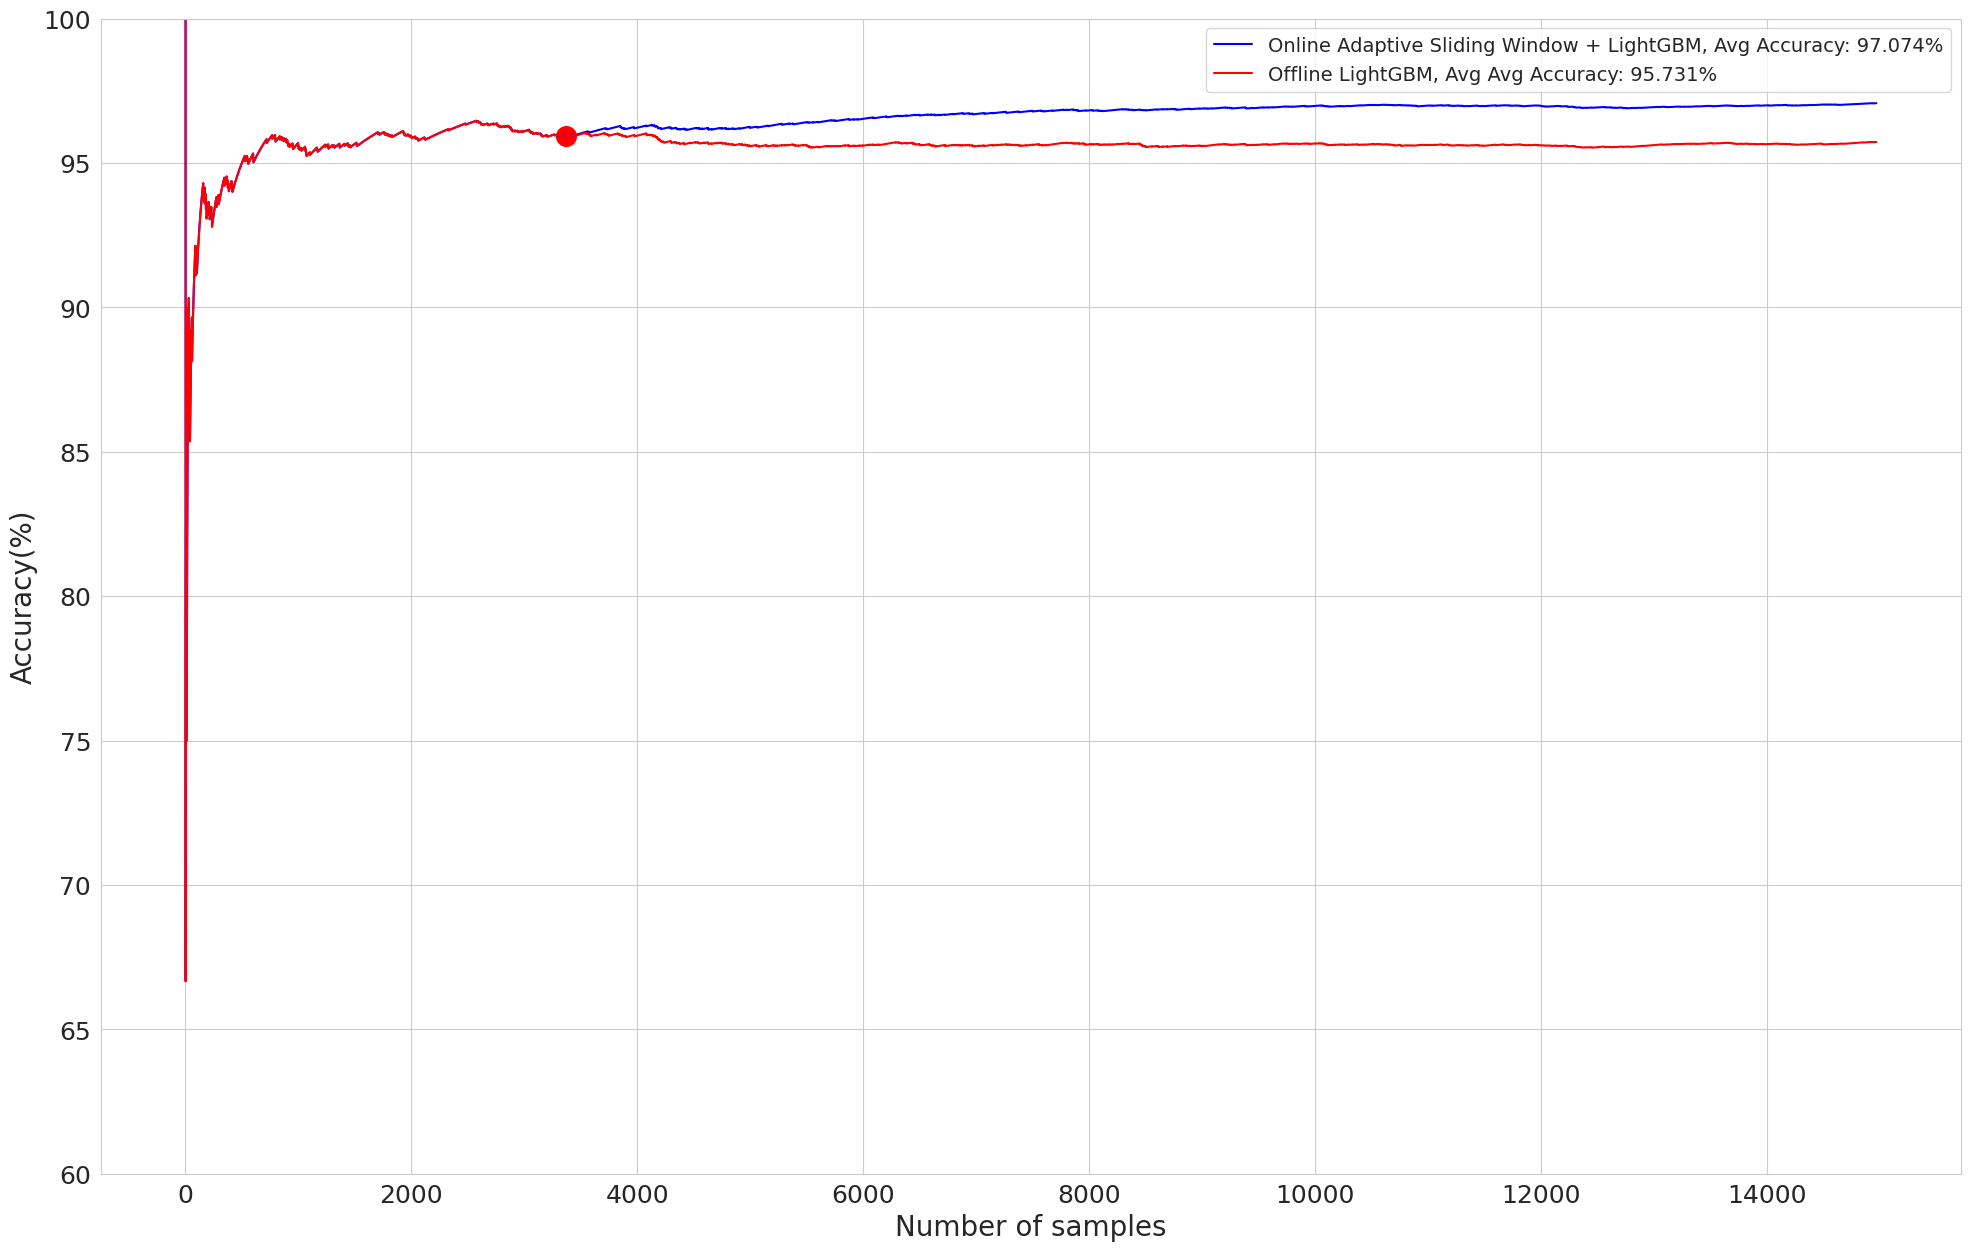

In [ ]:
# Assign the optimal hyperparameters detected by PSO
oasw_plot(a = 0.9816, b = 0.9707, win1 = 820, win2 = 4023)

In [ ]:
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp, average="weighted"),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp, average="weighted"),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp, average="weighted"),4)*100)+"%")
    return t, m

In [ ]:
def train_and_plot_models(train_data, test_data, datasetName):
    X_train=train_data.drop(columns=['label'])
    X_test=test_data.drop(columns=['label'])
    y_train=train_data['label']
    y_test=test_data['label']


    # Define models
    models = [
        ("ARF-ADWIN model", ensemble.AdaptiveRandomForestClassifier(n_models=2, drift_detector=ADWIN())),
        ("ARF-DDM model", ensemble.AdaptiveRandomForestClassifier(n_models=2, drift_detector=DDM(), warning_detector=DDM())),
        ("SRP-ADWIN model", ensemble.SRPClassifier(n_models=2, drift_detector=ADWIN())),
        ("SRP-DDM model", ensemble.SRPClassifier(n_models=2, drift_detector=DDM(), warning_detector=DDM())),
        ("EFDT model", tree.ExtremelyFastDecisionTreeClassifier()),
        ("HT model", tree.HoeffdingTreeClassifier()),
        ("LB model", ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(), n_models=2))
    ]




    # Initialize lists to store accuracy for each model
    accuracy_over_time = {name: [] for name, _ in models}

    # Train and evaluate each model
    for name, model in models:
        print(name)
        t, m = adaptive_learning(model, X_train, y_train, X_test, y_test)
        accuracy_over_time[name] = accuracy


    # # PWPAE model
    # print("PWPAE Model")
    # t, m = PWPAE(X_train, y_train, X_test, y_test)
    # accuracy_over_time["Proposed PWPAE model"] = m
    # print()

    # Plot accuracy over time for each model
    # plt.figure(figsize=(20, 10))
    plt.figure(figsize=(24, 15))
    #sns.set_style("darkgrid")

    for name, accuracy in accuracy_over_time.items():
        plt.plot(range(len(accuracy)), accuracy, label=f"{name}, Avg Accuracy: {np.mean(accuracy):.2f}%")

    plt.legend(loc='upper right')
    plt.ylim(58, 100)
    plt.xlabel('Number of samples', fontsize=20)
    plt.ylabel('Accuracy (%)', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(loc="lower left",fontsize=12)



    plt.show()

In [ ]:
def train_and_plot_models_OASW(train_data, test_data, datasetName):
    X_train=train_data.drop(columns=['label'])
    X_test=test_data.drop(columns=['label'])
    y_train=train_data['label']
    y_test=test_data['label']


    # Define models
    models = [
        ("ARF-ADWIN model", ensemble.AdaptiveRandomForestClassifier(n_models=2, drift_detector=ADWIN())),
        ("ARF-DDM model", ensemble.AdaptiveRandomForestClassifier(n_models=2, drift_detector=DDM(), warning_detector=DDM())),

        ("SRP-DDM model", ensemble.SRPClassifier(n_models=2, drift_detector=DDM(), warning_detector=DDM())),
        ("EFDT model", tree.ExtremelyFastDecisionTreeClassifier()),
        ("HT model", tree.HoeffdingTreeClassifier()),

    ]

    t_all=[]
    m_all=[]

    # Initialize lists to store accuracy for each model
    accuracy_over_time = {name: [] for name, _ in models}

    # Train and evaluate each model
    for name, model in models:
        print(name)
        _, accuracy = adaptive_learning(model, X_train, y_train, X_test, y_test)
        accuracy_over_time[name] = accuracy
        print()

    # # PWPAE model
    # print("PWPAE Model")
    # t, m = PWPAE(X_train, y_train, X_test, y_test)
    # accuracy_over_time["Proposed PWPAE model"] = m
    # print()

    # Plot accuracy over time for each model
    plt.figure(figsize=(20, 10))
    sns.set_style("darkgrid")

    for name, accuracy in accuracy_over_time.items():
        plt.plot(range(len(accuracy)), accuracy, label=f"{name}, Avg Accuracy: {np.mean(accuracy):.2f}%")
    # Assign the optimal hyperparameters detected by PSO
    # oasw_plot(a = 0.9729, b = 0.9781, win1 = 376, win2 = 1802)

    plt.legend(loc='upper right')
    plt.ylim(90, 102)
    plt.title(datasetName, fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')
    plt.show()

In [ ]:
def train_and_plot_models(train_data, test_data, datasetName):
    X_train=train_data.drop(columns=['label'])
    X_test=test_data.drop(columns=['label'])
    y_train=train_data['label']
    y_test=test_data['label']


    # Define models
    models = [
        ("ARF-ADWIN model", ensemble.AdaptiveRandomForestClassifier(n_models=2, drift_detector=ADWIN())),
        ("ARF-DDM model", ensemble.AdaptiveRandomForestClassifier(n_models=2, drift_detector=DDM(), warning_detector=DDM())),
        ("SRP-ADWIN model", ensemble.SRPClassifier(n_models=2, drift_detector=ADWIN())),
        ("SRP-DDM model", ensemble.SRPClassifier(n_models=2, drift_detector=DDM(), warning_detector=DDM())),
        ("EFDT model", tree.ExtremelyFastDecisionTreeClassifier()),
        ("HT model", tree.HoeffdingTreeClassifier()),
        ("LB model", ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(), n_models=2))
    ]

    # Initialize lists to store accuracy for each model
    accuracy_over_time = {name: [] for name, _ in models}

    # Train and evaluate each model
    for name, model in models:
        print(name)
        _, accuracy = adaptive_learning(model, X_train, y_train, X_test, y_test)
        accuracy_over_time[name] = accuracy


    # # PWPAE model
    # print("PWPAE Model")
    # t, m = PWPAE(X_train, y_train, X_test, y_test)
    # accuracy_over_time["Proposed PWPAE model"] = m
    # print()

    # Plot accuracy over time for each model
    plt.figure(figsize=(20, 10))
    sns.set_style("whitegrid")

    for name, accuracy in accuracy_over_time.items():
        plt.plot(range(len(accuracy)), accuracy, label=f"{name}, Avg Accuracy: {np.mean(accuracy):.2f}%")

    plt.legend(loc='lower right', fontsize="small")
    plt.ylim(30, 100)
    plt.xlabel('Number of samples', fontsize=20)
    plt.ylabel('Accuracy(%)', fontsize=20)
    plt.tick_params(axis='x', labelsize=15)  # Increase x-axis tick size
    plt.tick_params(axis='y', labelsize=15)  # Increase x-axis tick size

    plt.show()

ARF-ADWIN model
Accuracy: 95.72%
Precision: 95.67999999999999%
Recall: 95.72%
F1-score: 95.7%
ARF-DDM model
Accuracy: 95.47%
Precision: 95.52000000000001%
Recall: 95.47%
F1-score: 95.49%
SRP-ADWIN model
Accuracy: 95.98%
Precision: 95.89%
Recall: 95.98%
F1-score: 95.91%
SRP-DDM model
Accuracy: 97.34%
Precision: 97.39999999999999%
Recall: 97.34%
F1-score: 97.36%
EFDT model
Accuracy: 94.52000000000001%
Precision: 95.54%
Recall: 94.52000000000001%
F1-score: 94.78%
HT model
Accuracy: 94.83%
Precision: 96.02000000000001%
Recall: 94.83%
F1-score: 95.11%
LB model
Accuracy: 97.19%
Precision: 97.3%
Recall: 97.19%
F1-score: 97.23%


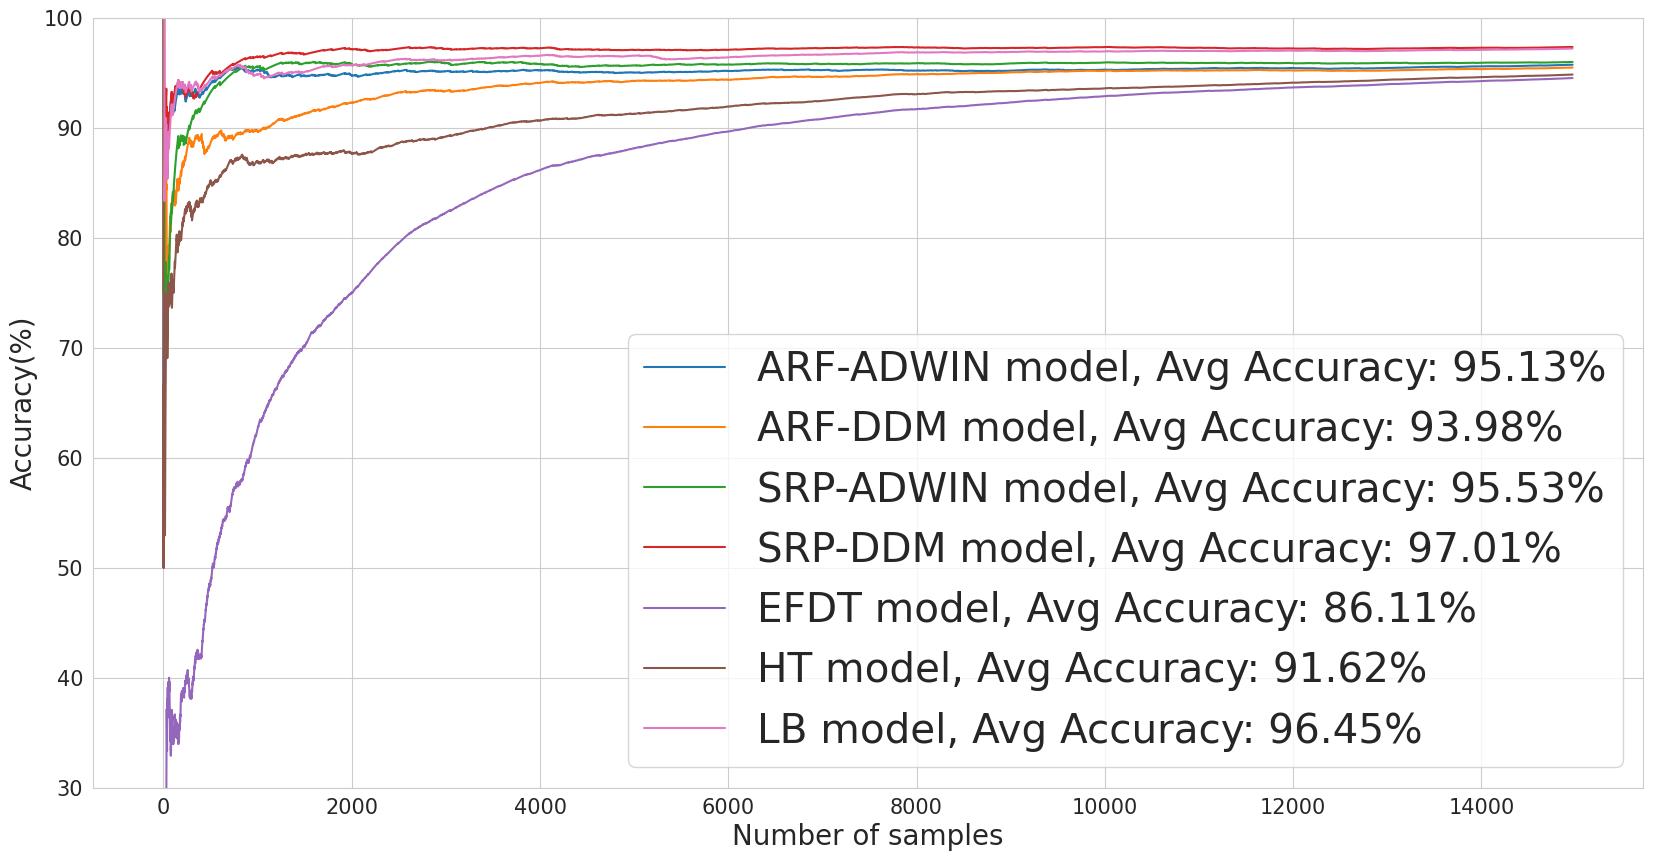

In [ ]:
train_and_plot_models(train_data_fumehood, test_data_fumehood, "FumeHood")

ARF-ADWIN model
Accuracy: 96.00999999999999%
Precision: 96.0%
Recall: 96.00999999999999%
F1-score: 96.00999999999999%

ARF-DDM model
Accuracy: 94.0%
Precision: 93.96%
Recall: 94.0%
F1-score: 93.97999999999999%

SRP-ADWIN model
Accuracy: 97.05%
Precision: 97.07000000000001%
Recall: 97.05%
F1-score: 97.06%

SRP-DDM model
Accuracy: 97.07000000000001%
Precision: 97.08%
Recall: 97.07000000000001%
F1-score: 97.08%

EFDT model
Accuracy: 92.75999999999999%
Precision: 93.63%
Recall: 92.75999999999999%
F1-score: 92.95%

HT model
Accuracy: 95.55%
Precision: 96.17%
Recall: 95.55%
F1-score: 95.66%

LB model
Accuracy: 97.78999999999999%
Precision: 97.87%
Recall: 97.78999999999999%
F1-score: 97.81%

[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points i

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LightGBM] [Info] Number of positive: 22229, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 22453, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990024 -> initscore=4.597507
[LightGBM] [Info] Start training from score 4.597507
[LightGBM] [Info] Number of positive: 93, number of negative: 284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Number of data points in the train set: 377, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.246684 -> initscore=-1.116375
[LightGBM] [Info] Start training from score -1.116375
[LightGBM] [Warning] No fu

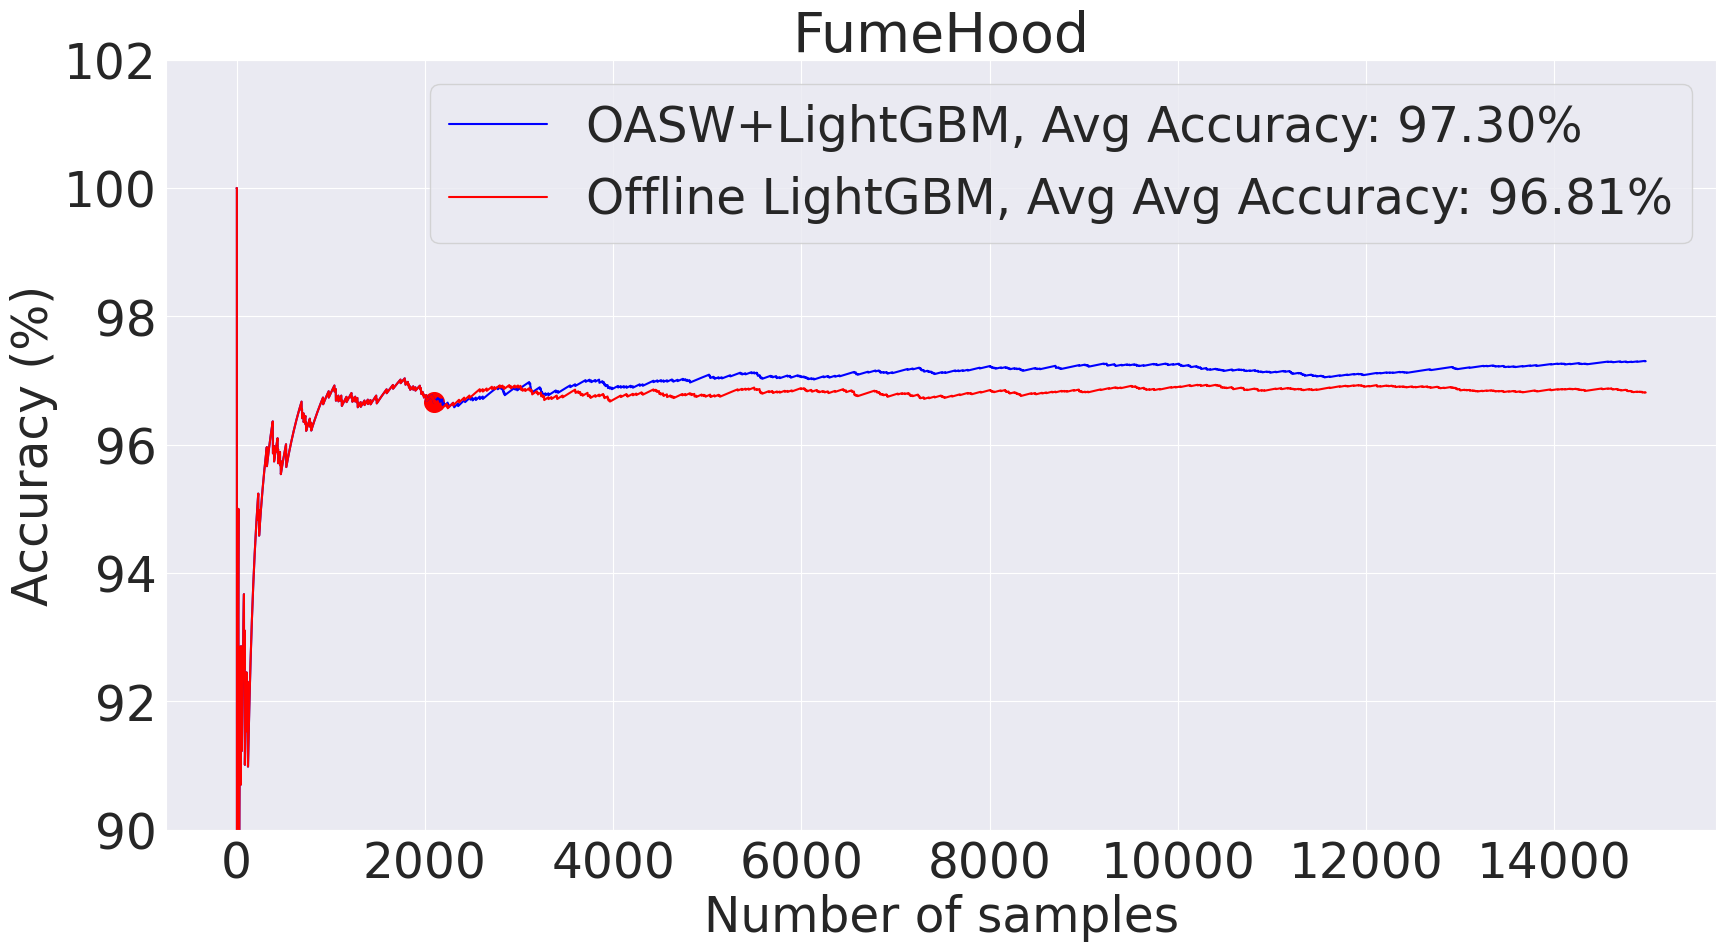

In [ ]:
train_and_plot_models_OASW(train_data_fumehood, test_data_fumehood, "FumeHood")